## Assumptions

### 1: Houses in the city will be more expensive in comparison to houses in the countryside

### 2: Big houses will be more expensive than smaller houses(both in the city and countryside)

### 3: Applying the wishes of stakeholder (aprox. 2 bedrooms, good condition, splitting city/countryside, no renovation in the countryside house) will be possible 

### 4: Big house in the city + big house in the countryside will be most expensive combination

# First overview of the data

In [178]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import folium
from folium.plugins import HeatMap

In [179]:
# read the original file
df = pd.read_csv("King_County_house_prices_dataset.csv")

# handling bathrooms
df["bathrooms"] = df["bathrooms"].apply(lambda x: round(x))

# convert variables
# following variables are in thousand dollars and sqft
df["price"] = df["price"].apply(lambda x: x*0.001)
df["sqft_lot"] = df["sqft_lot"].apply(lambda x: x*0.001)
df["sqft_living"] = df["sqft_living"].apply(lambda x: x*0.001)
df["sqft_above"] = df["sqft_above"].apply(lambda x: x*0.001)
df["sqft_living15"] = df["sqft_living15"].apply(lambda x: x*0.001)
df["sqft_lot15"] = df["sqft_lot15"].apply(lambda x: x*0.001)

df.sqft_basement = pd.to_numeric(df.sqft_basement, errors='coerce')
df["sqft_basement"] = df["sqft_basement"].apply(lambda x: x*0.001)

df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221.9,3,1,1.18,5.650,1.0,NaN,0.0,...,7,1.18,0.00,1955,0.0,98178,47.5112,-122.257,1.34,5.650
1,6414100192,12/9/2014,538.0,3,2,2.57,7.242,2.0,0.0,0.0,...,7,2.17,0.40,1951,1991.0,98125,47.7210,-122.319,1.69,7.639
2,5631500400,2/25/2015,180.0,2,1,0.77,10.000,1.0,0.0,0.0,...,6,0.77,0.00,1933,NaN,98028,47.7379,-122.233,2.72,8.062
3,2487200875,12/9/2014,604.0,4,3,1.96,5.000,1.0,0.0,0.0,...,7,1.05,0.91,1965,0.0,98136,47.5208,-122.393,1.36,5.000
4,1954400510,2/18/2015,510.0,3,2,1.68,8.080,1.0,0.0,0.0,...,8,1.68,0.00,1987,0.0,98074,47.6168,-122.045,1.80,7.503


In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  int64  
 5   sqft_living    21597 non-null  float64
 6   sqft_lot       21597 non-null  float64
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  float64
 13  sqft_basement  21143 non-null  float64
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

# Missing values

In [181]:
# check, how many nan values are in the data set

In [182]:
print("count of missing values:")
print("view:\t\t ", df.query("view == 'nan'").id.count())
print("waterfront:\t ", df.query("waterfront == 'nan'").id.count())
print("yr_renovated:\t ",df.query("yr_renovated == 'nan'").id.count())

count of missing values:
view:		  63
waterfront:	  2376
yr_renovated:	  3842


# Outliers

In [183]:
df = df.query("bedrooms < 33")

In [184]:
df = df.query("price < 1970.0")
print(df['price'].skew())

1.7334911526782086


In [185]:
df = df.query("sqft_lot < 107.157")
print(df['sqft_lot'].skew())

4.032033264450194


In [186]:
df = df.query("sqft_lot15 < 96.34557399999838")
print(df['sqft_lot15'].skew())

4.027076171545066


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20854 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20854 non-null  int64  
 1   date           20854 non-null  object 
 2   price          20854 non-null  float64
 3   bedrooms       20854 non-null  int64  
 4   bathrooms      20854 non-null  int64  
 5   sqft_living    20854 non-null  float64
 6   sqft_lot       20854 non-null  float64
 7   floors         20854 non-null  float64
 8   waterfront     18554 non-null  float64
 9   view           20794 non-null  float64
 10  condition      20854 non-null  int64  
 11  grade          20854 non-null  int64  
 12  sqft_above     20854 non-null  float64
 13  sqft_basement  20417 non-null  float64
 14  yr_built       20854 non-null  int64  
 15  yr_renovated   17123 non-null  float64
 16  zipcode        20854 non-null  int64  
 17  lat            20854 non-null  float64
 18  long  

# Distribution of price

count    20854.000000
mean       515.316288
std        282.849812
min         78.000000
25%        319.950000
50%        447.000000
75%        630.400000
max       1960.000000
Name: price, dtype: float64

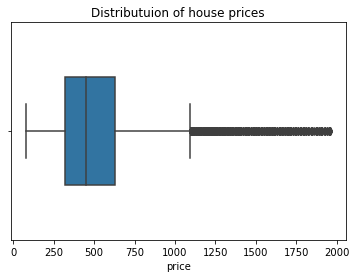

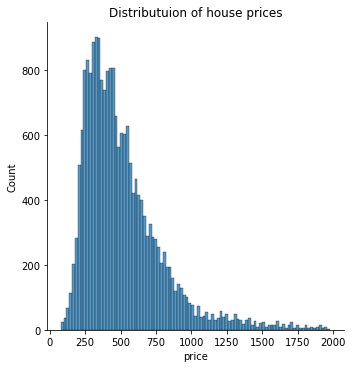

In [187]:
sns.boxplot( x=df["price"], width=0.5).set_title('Distributuion of house prices');
sns.displot(df, x=df["price"], bins=100, binwidth=20);
plt.title("Distributuion of house prices")
df.price.describe()

## Correlation between prices and size of living space

count    20854.000000
mean         2.033205
std          0.841666
min          0.370000
25%          1.410000
50%          1.890000
75%          2.500000
max          7.620000
Name: sqft_living, dtype: float64

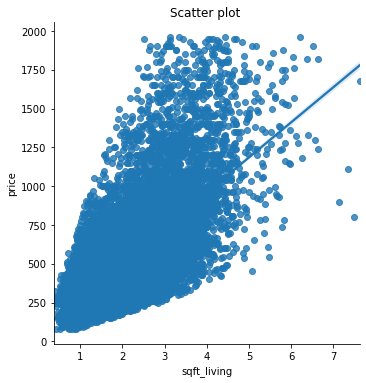

In [188]:
sns.lmplot('sqft_living', 'price',data=df);
plt.title("Scatter plot ")
df.sqft_living.describe()

### there seems to be a correlation!

# Split the data in city and nature dataframes

In [127]:
from bokeh.plotting import figure, output_notebook, show, output_file
from bokeh.tile_providers import get_provider, Vendors

# file to save the model  
#output_file("kcmap.html")  
output_notebook()
# instantiating the figure object  
graph = figure(title = "Map of House Sales in King County", x_axis_type="mercator", y_axis_type="mercator")
#tile provider
#tile_provider = get_provider(OSM)
#graph.add_tile(tile_provider)
# name of the x-axis  
graph.xaxis.axis_label = "Long"
# name of the y-axis  
graph.yaxis.axis_label = "Lat"
# points to be plotted converted to mercator
k = 6378137
x = df.long.apply(lambda x: x * (k * np.pi/180.0))
y = df.lat.apply(lambda x: np.log(np.tan((90 + x) * np.pi/360.0)) * k)
size = 2
# plotting the graph  
graph.scatter(x, y, 
              fill_alpha=0.1,
              size = size)  
# displaying the model  
show(graph)

Loading BokehJS ...

In [128]:
df_nature = df.query("long >= -122.2")
df_nature.shape

(8837, 21)

count    8837.000000
mean      525.844602
std       259.029877
min        80.000000
25%       334.950000
50%       470.000000
75%       655.000000
max      1960.000000
Name: price, dtype: float64

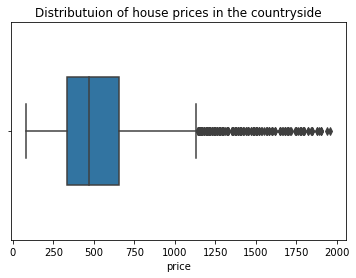

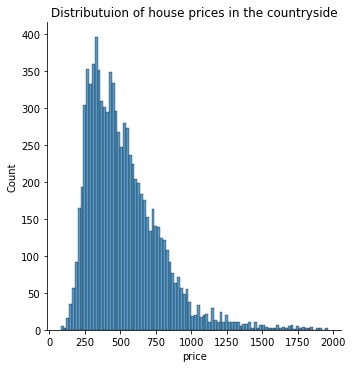

In [129]:
sns.boxplot( x=df_nature["price"], width=0.5).set_title('Distributuion of house prices in the countryside');
sns.displot(df_nature, x=df_nature["price"], bins=100, binwidth=20);
plt.title("Distributuion of house prices in the countryside")
df_nature.price.describe()

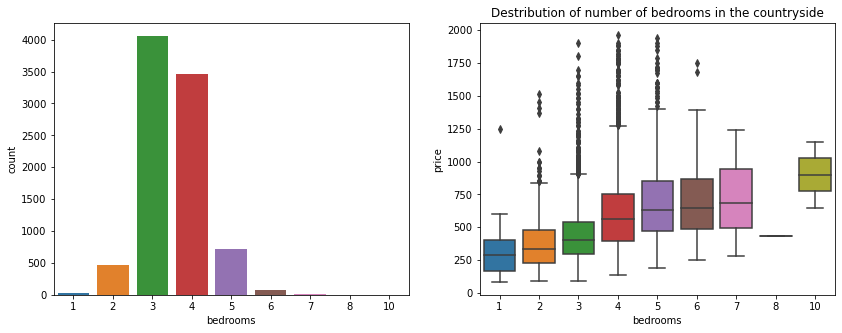

Text(0.5, 1.0, 'Scatter plot')

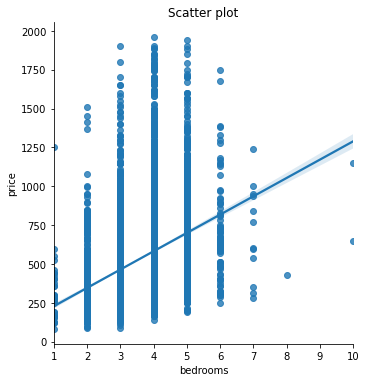

In [130]:
warnings.filterwarnings('ignore')

bedrooms = df_nature["bedrooms"].value_counts()

fig, ax = plt.subplots(ncols=2, figsize=(14,5))

sns.countplot(x='bedrooms', data=df_nature, ax=ax[0])
plt.title("Destribution of number of bedrooms in the countryside")
sns.boxplot(x='bedrooms', y= 'price',
            data=df_nature, ax=ax[1])

plt.show()


sns.lmplot('bedrooms', 'price',data=df_nature);
plt.title("Scatter plot")

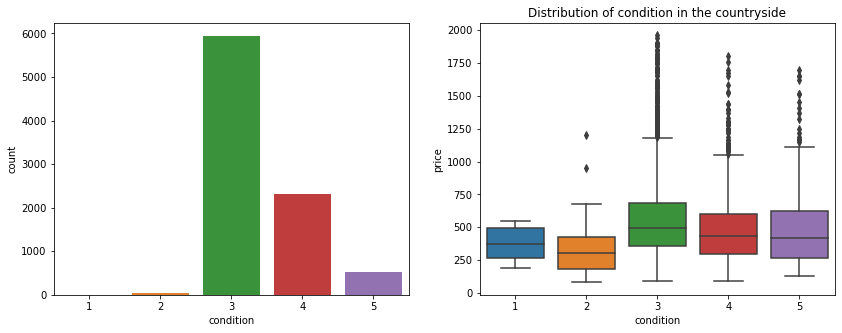

Text(0.5, 1.0, 'Scatter plot')

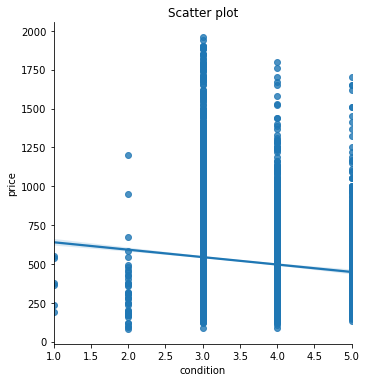

In [131]:
warnings.filterwarnings('ignore')

condition = df_nature["condition"].value_counts()

fig, ax = plt.subplots(ncols=2, figsize=(14,5))
sns.countplot(x='condition', data=df_nature, ax=ax[0])
plt.title("Distribution of condition in the countryside")
sns.boxplot(x='condition', y= 'price',
            data=df_nature, ax=ax[1])
plt.show()

sns.lmplot('condition', 'price',data=df_nature);
plt.title("Scatter plot")

# Add filters according to talk to stakeholder

In [132]:
df_nature = df_nature.query("bedrooms >= 2 and bedrooms <= 4 and condition >= 3 and yr_renovated == 0.0")
print(df_nature.shape)

(6404, 21)


count    6404.000000
mean      511.245467
std       245.694440
min        90.000000
25%       329.950000
50%       459.000000
75%       637.500000
max      1960.000000
Name: price, dtype: float64

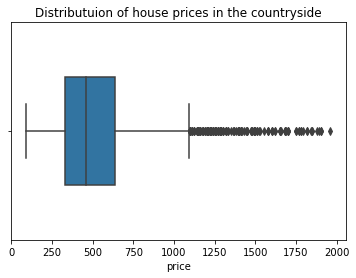

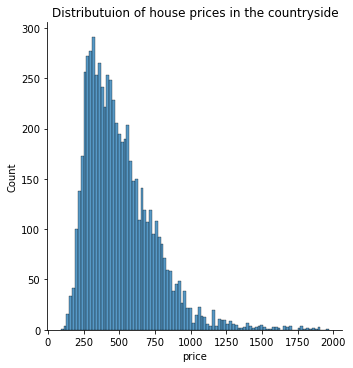

In [133]:
sns.boxplot( x=df_nature["price"], width=0.5).set_title('Distributuion of house prices in the countryside');
sns.displot(df_nature, x=df_nature["price"], bins=100, binwidth=20);
plt.title("Distributuion of house prices in the countryside")
df_nature.price.describe()

 no major changes in price distribution after apllying filters

## Map 

In [137]:
# Visualizing the surrounding 
maxpr=df_nature.loc[df_nature['price'].idxmax()]
#print(maxpr)
def generateBaseMap(default_location=[47.5112, -122.257], default_zoom_start=9.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

df_nature_copy = df_nature.copy()
df_nature_copy['count'] = 1
basemap = generateBaseMap()
folium.TileLayer('cartodbpositron').add_to(basemap)
s=folium.FeatureGroup(name='icon').add_to(basemap)
folium.Marker([maxpr['lat'], maxpr['long']],popup='Highest Price: $'+str(format(maxpr['price'],'.0f')),
              icon=folium.Icon(color='green')).add_to(s)
# add heatmap
HeatMap(data=df_nature_copy[['lat','long','count']].groupby(['lat','long']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)
basemap

## The city dataframe

In [139]:
df_city = df.query("long < -122.2")
df_city.shape
#df_city.long.describe()

(12017, 21)

count    12017.000000
mean       507.574031
std        298.932773
min         78.000000
25%        305.000000
50%        430.000000
75%        612.000000
max       1960.000000
Name: price, dtype: float64

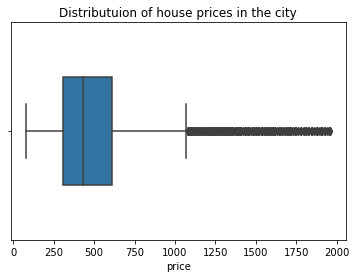

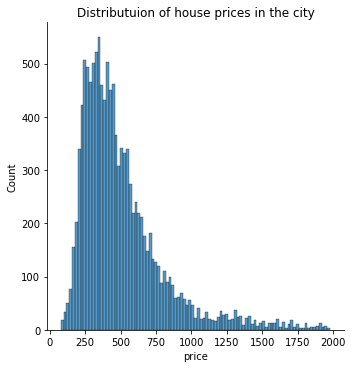

In [193]:
sns.boxplot( x=df_city["price"], width=0.5).set_title('Distributuion of house prices in the city');
sns.displot(df_city, x=df_city["price"], bins=100, binwidth=20);
plt.title("Distributuion of house prices in the city")
df_city.price.describe()

mean, median and distribution have similarities with countryside (slighlty lower). More outliers here

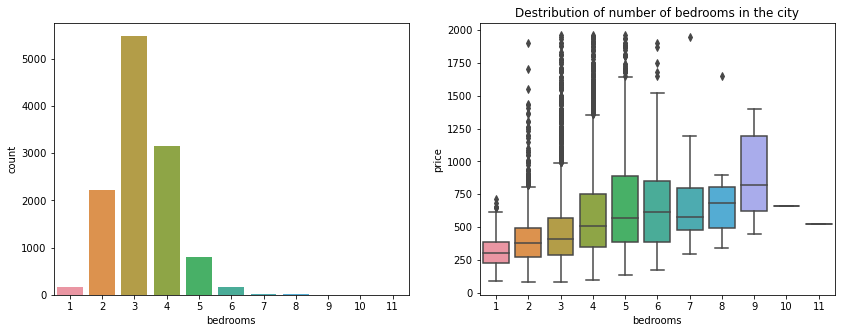

Text(0.5, 1.0, 'Scatter plot')

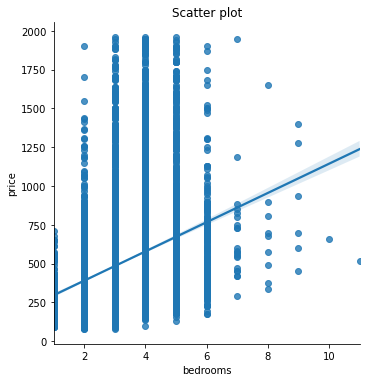

In [141]:
warnings.filterwarnings('ignore')

bedrooms = df_city["bedrooms"].value_counts()

fig, ax = plt.subplots(ncols=2, figsize=(14,5))

sns.countplot(x='bedrooms', data=df_city, ax=ax[0])
plt.title("Destribution of number of bedrooms in the city")
sns.boxplot(x='bedrooms', y= 'price',
            data=df_city, ax=ax[1])

plt.show()


sns.lmplot('bedrooms', 'price',data=df_city);
plt.title("Scatter plot")

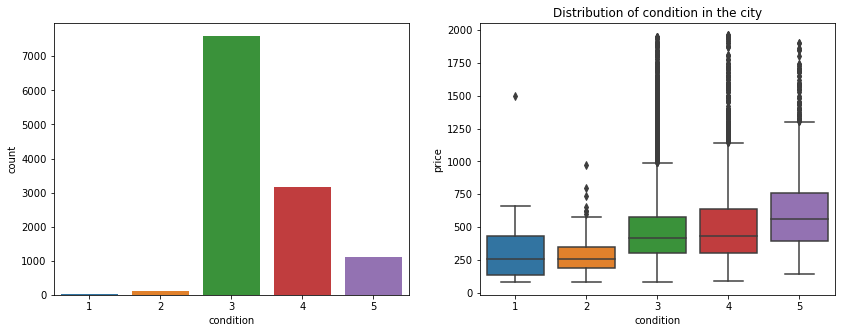

Text(0.5, 1.0, 'Scatter plot')

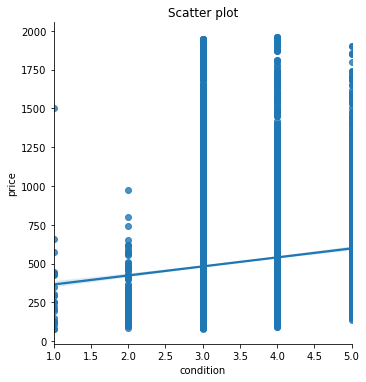

In [142]:
warnings.filterwarnings('ignore')

condition = df_city["condition"].value_counts()

fig, ax = plt.subplots(ncols=2, figsize=(14,5))
sns.countplot(x='condition', data=df_city, ax=ax[0])
plt.title("Distribution of condition in the city")
sns.boxplot(x='condition', y= 'price',
            data=df_city, ax=ax[1])
plt.show()

sns.lmplot('condition', 'price',data=df_city);
plt.title("Scatter plot")

# Add filters according to talk with stakeholder

In [61]:
df_city = df_city.query("bedrooms >= 2 and bedrooms <= 4 and condition >= 3")
df_city.shape

(17528, 21)

count    12017.000000
mean       507.574031
std        298.932773
min         78.000000
25%        305.000000
50%        430.000000
75%        612.000000
max       1960.000000
Name: price, dtype: float64

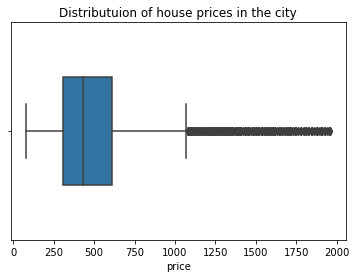

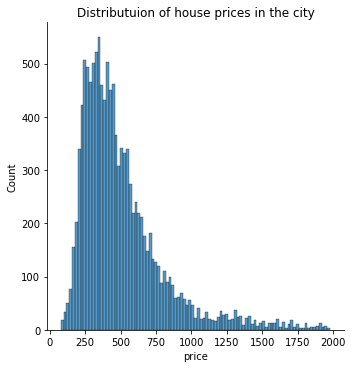

In [143]:
sns.boxplot( x=df_city["price"], width=0.5).set_title('Distributuion of house prices in the city');
sns.displot(df_city, x=df_city["price"], bins=100, binwidth=20);
plt.title("Distributuion of house prices in the city")
df_city.price.describe()

 no major changes

## Map

In [144]:
# Visualizing the surrounding 
maxpr=df_city.loc[df_city['price'].idxmax()]

def generateBaseMap(default_location=[47.5112, -122.257], default_zoom_start=9.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

df_city_copy = df_city.copy()
df_city_copy['count'] = 1
basemap = generateBaseMap()
folium.TileLayer('cartodbpositron').add_to(basemap)
s=folium.FeatureGroup(name='icon').add_to(basemap)
folium.Marker([maxpr['lat'], maxpr['long']],popup='Highest Price: $'+str(format(maxpr['price'],'.0f')),
              icon=folium.Icon(color='green')).add_to(s)
# add heatmap
HeatMap(data=df_city_copy[['lat','long','count']].groupby(['lat','long']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)
basemap

# Splitting into big and small houses

## Nature

### Small

In [146]:
df_nature_small = df_nature.query("sqft_living <= sqft_living.median()")
df_nature_small.shape

(3221, 21)

### Big

In [150]:
df_nature_big = df_nature.query("sqft_living > sqft_living.median()")
df_nature_big.shape

(3183, 21)

### City

### Small

In [154]:
df_city_small = df_city.query("sqft_living <= sqft_living.median()")
df_city_small.shape

(6080, 21)

### Big

In [156]:
df_city_big = df_city.query("sqft_living > sqft_living.median()")
df_city_big.shape

(5937, 21)

#### Comparison

In [205]:
print("city small:\t ", round(df_city_small.price.mean()), round(df_city_small.price.median()))
print("nature small:\t ", round(df_nature_small.price.mean()), round(df_nature_small.price.median()))
print("")
print("city big:\t ", round(df_city_big.price.mean()), round(df_city_big.price.median()))
print("nature big:\t ", round(df_nature_big.price.mean()), round(df_nature_big.price.median()))

city small:	  379 357
nature small:	  374 349

city big:	  639 551
nature big:	  650 616


in comparison to bigh houses in the countryside(median=616, mean=649),  big houses in the city tend to be cheaper

# Join the tables

### small_city and small_countryside

In [159]:
df_city_small['key'] = 1
df_nature_small['key'] = 1

result_cs_ns = pd.merge(df_city_small, df_nature_small, on ='key', suffixes=("_city", "_nature")).drop("key", 1) 

In [160]:
result_cs_ns["price"] = result_cs_ns["price_city"] + result_cs_ns["price_nature"]

### big_city and small_countryside

In [162]:
df_city_big['key'] = 1
df_nature_small['key'] = 1

result_cb_ns = pd.merge(df_city_big, df_nature_small, on ='key', suffixes=("_city", "_nature")).drop("key", 1)
result_cb_ns["price"] = result_cb_ns["price_city"] + result_cb_ns["price_nature"]

### small_city and big_countryside

In [164]:
df_city_small['key'] = 1
df_nature_big['key'] = 1

result_cs_nb = pd.merge(df_city_small, df_nature_big, on ='key', suffixes=("_city", "_nature")).drop("key", 1)
result_cs_nb["price"] = result_cs_nb["price_city"] + result_cs_nb["price_nature"]

### big_city and big_countryside

In [166]:
df_city_big['key'] = 1
df_nature_big['key'] = 1

result_cb_nb = pd.merge(df_city_big, df_nature_big, on ='key', suffixes=("_city", "_nature")).drop("key", 1)
result_cb_nb["price"] = result_cb_nb["price_city"] + result_cb_nb["price_nature"]

In [169]:
print("city:small and nature:small")
print("median: ", result_cs_ns.price.median(), "mean: ", result_cs_ns.price.mean() )
print("")
print("city:big and nature:small")
print("median: ", result_cb_ns.price.median(), "mean: ", result_cb_ns.price.mean() )
print("")
print("city:small and nature:big")
print("median: ", result_cs_nb.price.median(), "mean: ", result_cs_nb.price.mean() )
print("")
print("city:big and nature:big")
print("median: ", result_cb_nb.price.median(), "mean: ", result_cb_nb.price.mean() )

city:small and nature:small
median:  734.0 mean:  753.553374023012

city:big and nature:small
median:  935.0 mean:  1013.0181866277595

city:small and nature:big
median:  994.95 mean:  1029.344879652647

city:big and nature:big
median:  1209.95 mean:  1288.8096922573916


# Timing for countryside buy

In [174]:
df_nature_copy = df_nature.copy()

In [175]:
df_nature_copy["month"] = df_nature_copy["date"].apply(lambda x: x[0:2] if len(x) == 10 else x[0:1] )

In [176]:
pd.pivot_table(df_nature_copy, values="price", columns="month")

month,1,10,11,12,2,3,4,5,6,7,8,9
price,505.251702,495.351676,475.495078,494.183819,487.664821,505.707713,531.768424,507.005606,537.487589,524.165835,511.414174,509.711971


In [177]:
df_nature_copy.groupby("month").price.mean().sort_values()

month
11    475.495078
2     487.664821
12    494.183819
10    495.351676
1     505.251702
3     505.707713
5     507.005606
9     509.711971
8     511.414174
7     524.165835
4     531.768424
6     537.487589
Name: price, dtype: float64

# First results and insights

1: Prices in the city in general tend to be lower

2: There is a correlation between size of living space and price. Smaller houses are cheaper

3: No major differences between small-house prices in the city and in the countryside

4: Big houses in the countryside are more likely to be expensive than inn the city (Against my assumption)

5:  city:small and nature:small    median:  734.0 mean:  753.553374023012
    city:big and nature:small      median:  935.0 mean:  1013.0181866277595
    city:small and nature:big      median:  995.0 mean:  1029.344879652647
    city:big and nature:big        median:  1210.0 mean:  1288.8096922573916

6: In the wintertime, prices in the countryside tend to be lower

# Recommendations

1: If you want a big house --> buy in the city. But be aware that more space means higher costs

2: If you are looking for a small house, it does not really matter if the house is located in the city or in the countryside

3: Given the fact, that you are not in a rush to buy a house in the countryside, wait with it for the winter time

4: The combination city:big and nature:small may be the best option for you